In [1]:
import numpy as np
import torch
import scanpy as sc
from data import PertDataloader, Network


model_name = 'GNN_Disentangle_GAT_string_20.0_64_2_l3_Norman2019_gamma2_gene_emb_pert_emb_constant_lambda_emission'
args = np.load('./saved_args/'+model_name+'.npy', allow_pickle = True).item()
args['device'] = 'cuda:4'

In [2]:
args['test_perts'] = 'N/A'

In [3]:
if args['network_name'] == 'string':
    args['network_path'] = '/dfs/project/perturb-gnn/graphs/STRING_full_9606.csv'

if args['dataset'] == 'Norman2019':
    data_path = '/dfs/project/perturb-gnn/datasets/Norman2019_hvg+perts_more_de.h5ad'

adata = sc.read_h5ad(data_path)
if 'gene_symbols' not in adata.var.columns.values:
    adata.var['gene_symbols'] = adata.var['gene_name']
gene_list = [f for f in adata.var.gene_symbols.values]
# Set up message passing network
network = Network(fname=args['network_path'], gene_list=args['gene_list'],
                  percentile=args['top_edge_percent'])

# Pertrubation dataloader
pertdl = PertDataloader(adata, network.G, network.weights, args)

There are 101013 edges in the PPI.
Creating pyg object for each cell in the data...
Local copy of pyg dataset is detected. Loading...
Loading splits...
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Creating dataloaders....
Dataloaders created...


In [4]:
model = torch.load('./saved_models/' + model_name)
#model.pert_emb_agg = 'constant'
#model.lambda_emission = False
model.sim_gnn = False
model.args = args
from inference import evaluate, compute_metrics, deeper_analysis, GI_subgroup

test_res = evaluate(pertdl.loaders['test_loader'],
                        pertdl.loaders['edge_index'],
                        pertdl.loaders['edge_attr'], model, args)

test_metrics, test_pert_res = compute_metrics(test_res)

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/dfs/user/kexinh/miniconda3/

In [5]:
# calculate mean expression for each condition
unique_conditions = adata.obs.condition.unique()
conditions2index = {}
for i in unique_conditions:
    conditions2index[i] = np.where(adata.obs.condition == i)[0]
    
condition2mean_expression = {}
for i, j in conditions2index.items():
    condition2mean_expression[i] = np.mean(adata.X[j], axis = 0)
    
pert_list = np.array(list(condition2mean_expression.keys()))
mean_expression = np.array(list(condition2mean_expression.values())).reshape(len(adata.obs.condition.unique()), adata.X.toarray().shape[1])

ctrl = mean_expression[np.where(pert_list == 'ctrl')[0]]
most_variable_genes = np.argsort(np.std(mean_expression, axis = 0))[-200:]
gene_list = adata.var['gene_name'].values

In [6]:
form_AB_C = [('BCL2L11+BAK1', 'MAML2+ctrl', 0.3523299818794149),
 ('BCL2L11+TGFBR2', 'ctrl+PRTG', 0.6857607274776449),
 ('CDKN1C+CDKN1B', 'CDKN1A+ctrl', 0.8779019780110475),
 ('CEBPB+MAPK1', 'ctrl+ETS2', 0.8337438300302283),
 ('CEBPE+CEBPB', 'CEBPA+ctrl', 0.9459044940236668),
 ('CEBPE+CEBPB', 'ctrl+CEBPA', 0.9450568814100481),
 ('CEBPE+SPI1', 'CEBPA+ctrl', 0.9265882308117831),
 ('CEBPE+SPI1', 'ctrl+CEBPA', 0.9262205916083754),
 ('DUSP9+ETS2', 'ATL1+ctrl', 0.7880293527700989),
 ('DUSP9+IGDCC3', 'ATL1+ctrl', 0.8570524822236342),
 ('DUSP9+SNAI1', 'HOXA13+ctrl', 0.7996935838759098),
 ('DUSP9+SNAI1', 'ZBTB10+ctrl', 0.7995353929762368),
 ('ETS2+MAP7D1', 'ctrl+MAPK1', 0.7841776025156834),
 ('ETS2+MAP7D1', 'MAPK1+ctrl', 0.7803504300888134),
 ('FOSB+CEBPB', 'CEBPA+ctrl', 0.9354845938615464),
 ('FOSB+CEBPB', 'ctrl+CEBPA', 0.9354176324036135),
 ('FOSB+OSR2', 'CEBPE+ctrl', 0.8154604060988084),
 ('FOSB+UBASH3B', 'CEBPB+ctrl', 0.6317409516808135),
 ('FOXF1+FOXL2', 'C3orf72+ctrl', 0.8889870382378344),
 ('FOXL2+MEIS1', 'C3orf72+ctrl', 0.8846717759603488),
 ('KLF1+COL2A1', 'COL1A1+ctrl', 0.5541335212725205),
 ('LYL1+IER5L', 'ATL1+ctrl', 0.7404815124117897),
 ('MAP2K3+SLC38A2', 'ctrl+MAP2K6', 0.7593659002942127),
 ('MAP2K3+SLC38A2', 'MAP2K6+ctrl', 0.7391185919257972),
 ('MAP2K6+SPI1', 'ctrl+CEBPB', 0.558469704875895),
 ('MAPK1+TGFBR2', 'ctrl+ETS2', 0.9314792135449927),
 ('MAPK1+TGFBR2', 'ETS2+ctrl', 0.9204283415329652),
 ('PLK4+STIL', 'HOXA13+ctrl', 0.674186951565633),
 ('POU3F2+FOXL2', 'C3orf72+ctrl', 0.874822568078057),
 ('SGK1+S1PR2', 'SAMD1+ctrl', 0.6937735420993153),
 ('SGK1+TBX3', 'TP73+ctrl', 0.6898264549412313),
 ('TGFBR2+C19orf26', 'ATL1+ctrl', 0.8749178401903432),
 ('TGFBR2+ETS2', 'MAPK1+ctrl', 0.8111119211411146),
 ('TGFBR2+ETS2', 'ctrl+MAPK1', 0.8036455728715278),
 ('UBASH3B+PTPN9', 'PTPN1+ctrl', 0.9243948368096824),
 ('ZBTB10+PTPN12', 'HOXA13+ctrl', 0.720459826421656),
 ('ZC3HAV1+CEBPE', 'FOSB+ctrl', 0.6923524330291644),
 ('ZC3HAV1+HOXC13', 'HOXA13+ctrl', 0.8100287557856198),
 ('ZC3HAV1+HOXC13', 'RHOXF2BB+ctrl', 0.6674925920417053),
 ('ZNF318+FOXL2', 'C3orf72+ctrl', 0.8372164786681434)]

In [8]:
from utils import parse_single_pert, parse_any_pert

In [9]:
corr_fold_changes = []
for c in form_AB_C:
    q1 = c[0]
    q2 = c[1]
    
    i = np.where(pert_list == q1)[0]
    pert = mean_expression[i]
    
    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    fold_change[0][np.where(pert[0] < 0.1)[0]] = 0
    fc = fold_change[0][np.where(gene_list == parse_single_pert(q2))[0]]
    
    corr_fold_changes.append((fc[0], c[2]))

/tmp/ipykernel_77610/1744984347.py:9: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_77610/1744984347.py:9: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl


In [81]:
from scipy import stats
k = 20
def get_fc_AB_C(c):    

    i = np.where(pert_list == c)[0]
    pert = mean_expression[i]
    
    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    fold_change[0][np.where(pert[0] < 0.5)[0]] = 0
    
    topk_fold_changes = np.argsort(fold_change)[0][-k:]
    c1 = pert[:, topk_fold_changes].reshape(1,-1)
    c2 = ctrl[:, topk_fold_changes].reshape(1,-1)
    topk_fc_genes = gene_list[topk_fold_changes]
    
    for x in topk_fc_genes:
        for c2 in pert_list:
            if c!=c2 and c2 != 'ctrl' and len(np.intersect1d(parse_any_pert(c), parse_any_pert(c2)))==0:
                parse = parse_any_pert(c2)
                if x in parse and len(parse) == 1:
                    c2_exp = mean_expression[np.where(pert_list == c2)[0]]
                    fc = fold_change[0][np.where(gene_list == parse[0])[0]]
                    if fc[0] > 5:
                        corr_fc.append((c, c2, fc[0], 
                                    stats.pearsonr(c2_exp[:, most_variable_genes][0] - ctrl[:, most_variable_genes][0], 
                                                   pert[:, most_variable_genes][0] - ctrl[:, most_variable_genes][0])[0],
                                    ))
                    
    return corr_fc

In [82]:
from tqdm import tqdm
corr_fc = []
for c in tqdm(pert_list):
    if c!='ctrl':
        a = get_fc_AB_C(c)

  0%|                                                                                          | 0/284 [00:00<?, ?it/s]/tmp/ipykernel_77610/3917558323.py:8: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_77610/3917558323.py:8: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl
100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [00:44<00:00,  6.35it/s]


/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


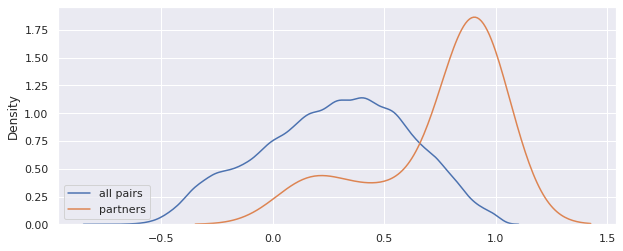

In [33]:
import seaborn as sns
import pandas as pd
sns.set(rc={'figure.figsize':(10, 4)})
import matplotlib.pyplot as plt
corr = pd.DataFrame(mean_expression[:, most_variable_genes] - ctrl[:, most_variable_genes]).T.corr('pearson').values
sns.distplot(corr.reshape(-1,), hist = False, label = 'all pairs')
ax = sns.distplot([i[3] for i in corr_fc], hist = False, label = 'partners')
#ax.set_xlim(0, 1)
plt.legend(loc='lower left', labels=['all pairs', 'partners'])


In [38]:
df_corr_fc = pd.DataFrame(corr_fc)
df_corr_fc = df_corr_fc.rename(columns = {0: 'query_pert', 1: 'act_pert', 
                             2: 'fold_change', 3: 'pearson', 4: 'spearman'})

In [39]:
def gene2type(c):
    out = []
    o = parse_any_pert(c)
    for i in o:
        if i in gene2status:
            out.append(gene2status[i])
        else:
            out.append('N/A')
            
    return '+'.join(out)

In [40]:
import pandas as pd
df_pert_status = pd.read_excel('./perturbation_status.xlsx')[['gene_name', 'gene type']]
df_pert_status = df_pert_status[df_pert_status['gene type'] != 'poorly characterized']
gene2status = dict(df_pert_status.values)

In [41]:
df_corr_fc['query_type'] = df_corr_fc.query_pert.apply(lambda x: gene2type(x))
df_corr_fc['act_type'] = df_corr_fc.act_pert.apply(lambda x: gene2type(x))

In [42]:
df_corr_fc

,query_pert,act_pert,fold_change,pearson,query_type,act_type
0,DUSP9+MAPK1,ctrl+ETS2,7.202773,0.224872,signaling+signaling,transcription factor
1,DUSP9+MAPK1,ETS2+ctrl,7.202773,0.211482,signaling+signaling,transcription factor
2,IGDCC3+MAPK1,ctrl+ETS2,6.974825,0.531236,immunoglobulin DCC subtype+signaling,transcription factor
3,IGDCC3+MAPK1,ETS2+ctrl,6.974825,0.515201,immunoglobulin DCC subtype+signaling,transcription factor
4,JUN+CEBPA,ctrl+CEBPE,46.594349,0.910482,transcription factor+transcription factor,transcription factor
5,JUN+CEBPA,CEBPE+ctrl,46.594349,0.890260,transcription factor+transcription factor,transcription factor
6,MAPK1+IKZF3,ctrl+ETS2,6.793534,0.120023,signaling+transcription factor,transcription factor
7,MAPK1+IKZF3,ETS2+ctrl,6.793534,0.101036,signaling+transcription factor,transcription factor
8,CEBPB+CEBPA,ctrl+CEBPE,57.989193,0.904909,transcription factor+transcription factor,transcription factor
9,CEBPB+CEBPA,CEBPE+ctrl,57.989193,0.886019,transcription factor+transcription factor,transcription factor


/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


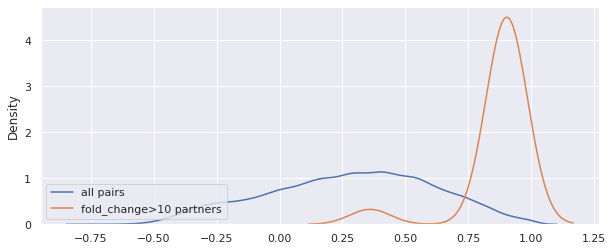

In [45]:
corr = pd.DataFrame(mean_expression[:, most_variable_genes] - ctrl[:, most_variable_genes]).T.corr('pearson').values
sns.distplot(corr.reshape(-1,), hist = False, label = 'all pairs')
ax = sns.distplot([i[3] for i in corr_fc if i[2] > 10], hist = False, label = 'partners')
#ax.set_xlim(0, 1)
plt.legend(loc='lower left', labels=['all pairs', 'fold_change>10 partners'])


In [43]:
corr_fc

[('DUSP9+MAPK1', 'ctrl+ETS2', 7.2027726, 0.2248723194515711),
 ('DUSP9+MAPK1', 'ETS2+ctrl', 7.2027726, 0.2114824372412458),
 ('IGDCC3+MAPK1', 'ctrl+ETS2', 6.9748254, 0.53123589090295),
 ('IGDCC3+MAPK1', 'ETS2+ctrl', 6.9748254, 0.5152008954460507),
 ('JUN+CEBPA', 'ctrl+CEBPE', 46.59435, 0.9104819582942012),
 ('JUN+CEBPA', 'CEBPE+ctrl', 46.59435, 0.8902604151930988),
 ('MAPK1+IKZF3', 'ctrl+ETS2', 6.793534, 0.12002348228650378),
 ('MAPK1+IKZF3', 'ETS2+ctrl', 6.793534, 0.10103579598065632),
 ('CEBPB+CEBPA', 'ctrl+CEBPE', 57.989193, 0.9049085131749673),
 ('CEBPB+CEBPA', 'CEBPE+ctrl', 57.989193, 0.8860189186921714),
 ('CNN1+MAPK1', 'ctrl+ETS2', 6.9101076, 0.7563005883706281),
 ('CNN1+MAPK1', 'ETS2+ctrl', 6.9101076, 0.7425928574120746),
 ('MAPK1+TGFBR2', 'ctrl+ETS2', 7.4403806, 0.9686621559479754),
 ('MAPK1+TGFBR2', 'ETS2+ctrl', 7.4403806, 0.9617550084431395),
 ('ctrl+CEBPA', 'ctrl+CEBPE', 53.700356, 0.9131265499455211),
 ('ctrl+CEBPA', 'CEBPE+ctrl', 53.700356, 0.8937527496539927),
 ('FOSB+CE

## how many TFs are there?

In [46]:
train_perts = pertdl.set2conditions['train']

In [83]:
fold_change_all = []
for c in pert_list:
    i = np.where(pert_list == c)[0]
    pert = mean_expression[i]

    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    fold_change[0][np.where(pert[0] < 0.5)[0]] = 0
    fold_change_all.append(fold_change[0])
    
fold_change_all = np.stack(fold_change_all)


/tmp/ipykernel_77610/283273026.py:6: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_77610/283273026.py:6: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl


In [84]:
train_pert = train_perts[0]
pert2high_folds_up = {}

for train_pert in train_perts:
    o = np.where(fold_change_all[np.where(pert_list == train_pert)[0]][0] > 10)[0]
    if len(o) > 0:
        pert2high_folds_up[train_pert] = gene_list[o].tolist()

In [85]:
all_high_folds = []
for i in pert2high_folds_up.values():
    all_high_folds = all_high_folds + i
all_high_folds = np.unique(all_high_folds)

In [86]:
TFs = pd.read_csv('TF_names_v_1.01.txt', header = None).values.reshape(-1,)

In [87]:
len(all_high_folds)

69

In [88]:
all_high_folds

array(['ACSL1', 'AHR', 'AP003068.23', 'ARHGDIB', 'AVP', 'C10orf54',
       'CD48', 'CD84', 'CEBPA', 'CEBPE', 'CHI3L2', 'CITED1', 'CLC',
       'CNN1', 'COL9A2', 'CORO1A', 'CRYBA2', 'CRYM', 'CSF3R', 'CTTNBP2',
       'CYBRD1', 'DLX2', 'EVI2B', 'FOXO4', 'GLIPR1', 'GSN', 'HAMP',
       'HBA2', 'HBE1', 'HES7', 'HP', 'ID2', 'IER5L', 'IGDCC3', 'IGFBP4',
       'IL2RG', 'IRF1', 'ITGB2', 'JUN', 'LHX1', 'LST1', 'MAP2K3', 'MS4A3',
       'MYO1F', 'NCF1', 'NOX5', 'OSR2', 'PLEK', 'PNRC1', 'PRG2', 'PRG3',
       'PRTG', 'PSMB9', 'RASSF2', 'RGS18', 'RP11-445F12.1',
       'RP11-887P2.5', 'RSAD2', 'SELPLG', 'SGK1', 'SLC44A1', 'SP6',
       'SRGN', 'TAP1', 'TFF3', 'TMEM158', 'TNFSF10', 'TYROBP', 'VASN'],
      dtype='<U13')

In [89]:
np.intersect1d(all_high_folds, TFs)

array(['AHR', 'CEBPA', 'CEBPE', 'DLX2', 'FOXO4', 'HES7', 'IRF1', 'JUN',
       'LHX1', 'OSR2', 'SP6'], dtype=object)

In [90]:
out = deeper_analysis(adata, test_res)

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:262: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

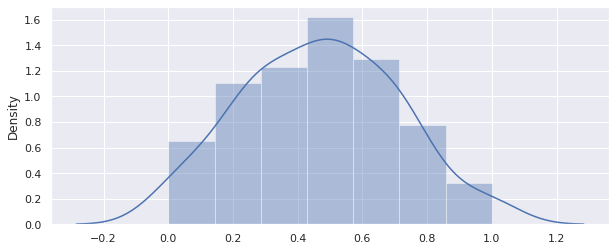

In [94]:
sns.distplot([i['frac_in_range_25_75'] for i in out.values() if 'frac_in_range_25_75' in i])